<a href="https://colab.research.google.com/github/fajarathallah/Capstone_Project_Model_IBM/blob/main/Main_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install langchain_community
!pip install replicate
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

In [18]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d shanegerami/ai-vs-human-text
!unzip ai-vs-human-text.zip

In [21]:
import pandas as pd
data = pd.read_csv('AI_Human.csv')
data.head()

,text,generated
0,Cars. Cars have been around since they became ...,0.0
1,Transportation is a large necessity in most co...,0.0
2,"""America's love affair with it's vehicles seem...",0.0
3,How often do you ride in a car? Do you drive a...,0.0
4,Cars are a wonderful thing. They are perhaps o...,0.0


In [22]:
print(data.isna().sum())
print(data.isnull().sum())

text         0
generated    0
dtype: int64
text         0
generated    0
dtype: int64


In [23]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 487235 entries, 0 to 487234
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   text       487235 non-null  object 
 1   generated  487235 non-null  float64
dtypes: float64(1), object(1)
memory usage: 7.4+ MB
None


Terdapat 487.234 data dalam dataset

Melihat distribusi data

In [24]:
data['labelling'] = data['generated'].map({0 :'AI generated', 1 :'Human'})


In [25]:
# hitung jumlah
label_counts = data['labelling'].value_counts()
print(f'Distribusi label: {label_counts}')

Distribusi label: labelling
AI generated    305797
Human           181438
Name: count, dtype: int64


/tmp/ipython-input-26-3536387019.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data, x = 'labelling', palette = 'pastel')


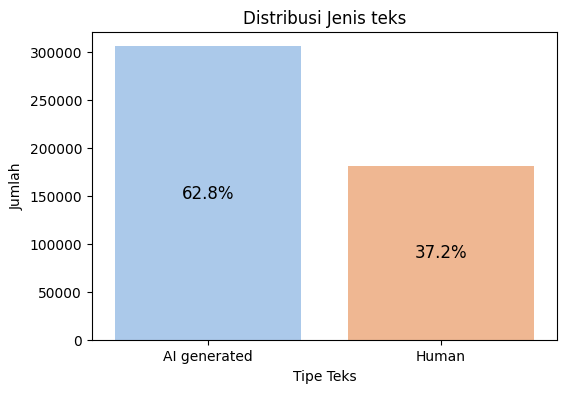

In [26]:
# Visualisasi nya
import matplotlib.pyplot as plt
import seaborn as sns

total = label_counts.sum()

plt.figure(figsize=(6,4))
ax = sns.countplot(data, x = 'labelling', palette = 'pastel')

for p in ax.patches:
    count = p.get_height()
    percentage = 100 * count / total
    x = p.get_x() + p.get_width() / 2.
    y = count / 2  # posisi teks di tengah batang
    ax.annotate(f'{percentage:.1f}%', (x, y),
                ha='center', va='center', fontsize=12, color='black')

plt.title('Distribusi Jenis teks')
plt.xlabel('Tipe Teks')
plt.ylabel('Jumlah')
plt.show()

In [66]:
from langchain_community.llms import Replicate
import os
from google.colab import userdata
# Set the API token
api_token = userdata.get('token_project')
os.environ["REPLICATE_API_TOKEN"] = api_token
# Model setup
model = "ibm-granite/granite-3.3-8b-instruct"
output = Replicate(
model=model,
replicate_api_token=api_token,
)

In [67]:
def build_prompt(text):
  return f"""
  Determine if the text was written by an AI or Human. Respond with "AI" or "Human".

Text:
{text}
"""

def build_style_prompt(text):
  return f"""
  "Classify the text as AI or Human. Give a short explanation (max 1 sentence) highlighting the key writing trait that justifies the label."

Text:
{text}
"""

parameters = {
    "top_k":3,
    "top_p":1.0,
    "max_tokens":128,
    "temperature":0.3,
    "repetition_penalty":1.0,
    "stopping_criteria":"length(128)",
    "stopping_sequence":None,
    "random_seed": None
}

In [70]:
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split

data_sample,_ = train_test_split(
    data,
    train_size =1000,
    stratify = data['generated'],
    random_state = 42
)

data_sample = data_sample.sample(30, random_state=42).copy()

data_sample['granite_pred'] = ''
data_sample['style_analysis'] = ''

for i, row in tqdm(data_sample.iterrows(), total = len(data_sample)):
  text = row['text']

  #Klasifikasi AI/Human
  classify_prompt = build_prompt(text)
  pred = output.invoke(classify_prompt, parameters)

  #Style Penulisan
  style_prompt = build_style_prompt(text)
  style = output.invoke(style_prompt, parameters)

  #Hasil
  data_sample.at[i, 'granite_pred'] = str(pred).strip()
  data_sample.at[i, 'style_analysis'] = str(style).strip()


  3%|▎         | 1/30 [01:23<40:16, 83.33s/it]


RuntimeError: Director: unexpected error handling prediction (E9243)

In [48]:
pd.set_option('display.max_colwidth', None)  # supaya kolom tidak terpotong
data_sample[['labelling', 'granite_pred', 'style_analysis']].head(5)

,labelling,granite_pred,style_analysis
329187,Human,Human,"AI. This text is classified as AI due to its consistent use of non-standard abbreviations (e.g., ""Ahab"" for ""a lot of,"" ""NOA"" for ""not all,"" ""AHE"" for ""a high percentage of"") and repetitive phrasing (""It's also important AO ...,"" ""For example, Thomas Edison, AHE inventor of AHE light bulb...""). These traits are indicative of a language model's tendency to repeat phrases or use inaccurate substitutions, rather than the natural variability and precision seen in human writing."
205121,AI generated,Human,"AI. The text is classified as AI due to its repetitive use of the phrase ""ANR"" without clear definition or context, indicating a lack of human-like nuanced understanding or editing.\n\nExplanation: The text repeatedly uses ""ANR"" without clarification, which suggests automated generation or copying without human review to correct or define abbreviations, a trait more common in AI-generated text than in human writing."
144552,AI generated,Human,"AI. The text is written in a persuasive, logical manner, using structured arguments and hypothetical scenarios, which is characteristic of AI-generated content aiming to convince through reason and data-like presentation, rather than the more varied and emotionally nuanced style typically found in human writing."
449447,AI generated,Human,"**Label:** Human\n\n**Explanation:** The text exhibits a conversational tone, with colloquial language (""got it,"" ""who knows""), personal opinions, and a narrative structure that includes anecdotes and direct quotes, suggesting a human author rather than an AI-generated one."
486953,AI generated,Human,"AI\n\nExplanation: The text exhibits a formal, informative, and objective tone, with precise details and technical language about Venus's conditions and proposed exploration methods, typical of AI-generated content summarizing research articles."


Ringkasan gaya tulisan AI dan Human

In [55]:
def summarize_style(text_series, label="AI"):
  examples = "\n".join(text_series.dropna().astype(str).tolist()[:30])
  prompt = f'''
  Summarize the writing charateristics of the following texts written by {label} by highlights key points in 3 points. Example, AI give 3 points and Human give 3 points. All include in max 1 senteces.

Descriptions:
{examples}
'''
  summary = output.invoke(prompt, parameters)
  return str(summary).strip()

summary_ai = summarize_style(data_sample[data_sample['generated'] == 0]['style_analysis'], label="AI")
summary_human = summarize_style(data_sample[data_sample['generated'] == 1]['style_analysis'], label="Human")


print(f"Ringkasan gaya tulisan: {summary_human}")


Ringkasan gaya tulisan: **AI Text Characteristics:**

1. **Formal, Informative Tone:** AI texts often maintain a formal, objective tone, presenting factual information devoid of personal opinions or emotions, as seen in descriptions of the Face on Mars or benefits of limiting car usage.
2. **Non-standard Language Use:** AI writing frequently employs unusual abbreviations (e.g., "HPS," "Hays"), intentional misspellings, or coded language ("SPQR"), attempting to obfuscate its artificial origin.
3. **Logical Coherence with Inconsistencies:** AI texts display coherent structures but may present logically inconsistent ideas or oversimplify complex matters, lacking the nuanced understanding and natural error patterns typical of human writing, as evident in discussions on work-life balance.

**Human Text Characteristics:**

1. **Detailed, Technical Explanations:** Human writing is marked by comprehensive, systematic explanations, like the detailed breakdown of the Facial Action Coding System,

Klasifikasi report

In [58]:
#from sklearn.metrics import classification_report
#import pandas as pd

#def evaluate_prediction(df, true_col='generated', pred_col='granite_pred', verbose=True):
    """
    Evaluasi prediksi biner (AI = 0, Human = 1) dari model, meskipun hasil timpang atau ada NaN.

    Params:
    - df: DataFrame yang memuat data
    - true_col: Nama kolom ground truth (default: 'generated')
    - pred_col: Nama kolom prediksi model (default: 'granite_pred')
    - verbose: Jika True, print classification_report. Jika False, hanya return dict.

    Returns:
    - classification_report (dict format)
    """
    # Bersihkan prediksi (strip & lowercase)
    df = df.copy()
    df['__pred_clean'] = df[pred_col].astype(str).str.strip().str.lower()

    # Ambil hanya prediksi yang valid
    valid = df[df['__pred_clean'].isin(['ai', 'human'])].copy()
    valid['__pred_binary'] = valid['__pred_clean'].map({'ai': 0, 'human': 1})

    # Optional: cetak warning kalau ada yang dibuang
    dropped = len(df) - len(valid)
    if dropped > 0:
        print(f"{dropped} baris prediksi diabaikan karena tidak valid ('ai' atau 'human').")

    # Buat laporan klasifikasi
    report = classification_report(
        valid[true_col],
        valid['__pred_binary'],
        labels=[0, 1],
        target_names=['AI', 'Human'],
        zero_division=0,
        output_dict=True
    )

    if verbose:
        print("Classification Report:\n")
        print(classification_report(
            valid[true_col],
            valid['__pred_binary'],
            labels=[0, 1],
            target_names=['AI', 'Human'],
            zero_division=0
        ))

    return report


In [59]:
#evaluate_prediction(data_sample)


1 baris prediksi diabaikan karena tidak valid ('ai' atau 'human').
Classification Report:

              precision    recall  f1-score   support

          AI       0.00      0.00      0.00        19
       Human       0.34      1.00      0.51        10

    accuracy                           0.34        29
   macro avg       0.17      0.50      0.26        29
weighted avg       0.12      0.34      0.18        29



{'AI': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 19.0},
 'Human': {'precision': 0.3448275862068966,
  'recall': 1.0,
  'f1-score': 0.5128205128205128,
  'support': 10.0},
 'accuracy': 0.3448275862068966,
 'macro avg': {'precision': 0.1724137931034483,
  'recall': 0.5,
  'f1-score': 0.2564102564102564,
  'support': 29.0},
 'weighted avg': {'precision': 0.11890606420927469,
  'recall': 0.3448275862068966,
  'f1-score': 0.17683465959328026,
  'support': 29.0}}